In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import re
import phik
import warnings
import os
import optuna
import statsmodels.api as sma
import joblib

from catboost import CatBoostRegressor
from catboost import Pool, cv
from scipy import sparse
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer
from tqdm.notebook import trange, tqdm
from time import sleep

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.2f}'.format)
tqdm.pandas()

# Препроцессинг

In [2]:
df = pd.read_csv('/Users/prime/Documents/data/kaggle/eda_sales_cars.csv')

In [3]:
def check(df):
    l = []
    columns = df.columns
    for col in tqdm(columns):
        dtypes = df[col].dtypes
        nunique = df[col].nunique()
        len_col = len(df[col])
        sum_nan = df[col].isna().sum()
        count = df[col].count()
        per_nan = sum_nan/len_col * 100
        l.append([col, dtypes, nunique, len_col, sum_nan, count, per_nan])
    df_check = pd.DataFrame(l)
    df_check.columns=['column', 'dtypes', 'nunique', 'len_col', 'sum_nan', 'count', 'per_nan']
    return df_check

df_check = check(df)

display(df_check)

  0%|          | 0/19 [00:00<?, ?it/s]

column   dtypes  nunique  len_col  sum_nan    count  \
0                   brand   object       59  1040775        0  1040775   
1                    name   object      779  1040775        0  1040775   
2               body_type   object       11  1040775        0  1040775   
3                   color   object       15  1040775        0  1040775   
4               fuel_type   object        2  1040775        0  1040775   
5                    year    int64       58  1040775        0  1040775   
6                 mileage    int64      487  1040775        0  1040775   
7            transmission   object        4  1040775        0  1040775   
8                   power    int64      311  1040775        0  1040775   
9                   price    int64     2572  1040775        0  1040775   
10  vehicle_configuration   object     7552  1040775        0  1040775   
11            engine_name   object     1087  1040775        0  1040775   
12    engine_displacement  float64       55  1040775        0  1040775   
13               location   object       69  1040775        0  1040775   
14               lifetime  float64       50  1040775        0  1040775   
15                    age    int64       58  1040775        0  1040775   
16               mil_year    int64     3854  1040775        0  1040775   
17                tax_low    int64        2  1040775        0  1040775   
18                country   object       12  1040775        0  1040775   

    per_nan  
0      0.00  
1      0.00  
2      0.00  
3      0.00  
4      0.00  
5      0.00  
6      0.00  
7      0.00  
8      0.00  
9      0.00  
10     0.00  
11     0.00  
12     0.00  
13     0.00  
14     0.00  
15     0.00  
16     0.00  
17     0.00  
18     0.00

- Данные представлены набором данных из 18 признаков (столбцов) по 1 040 775 объявлениям о продаже автомобилей в Приморском крае. 
- В ходе EDA данные прошли предобработку и анализ данных. В полученном датасете отсуствуют пропуски, представлен оптимальный набор признаков, удалены лишние.
- Для дальнейшей работы мы выделим отдельно сет машин под маркой бренда Toyota, так как в виду особеннсотей региона половина всех объявлений представлена именно данными автомобилями. К тому же это будет менее ресурсоемко и позволит создать модель нацеленную на более точное предсказание цены именно данного бренда.

**Перечень признаков:**
- `brand` - марка автомобиля
- `name` - модель автомобиля
- `body_type` - тип кузова автомобиля
- `fuel_type` - используемое топливо для автомобиля
- `mileage` - пробег автомобиля
- `transmission` - тип трансмиссии автомобиля
- `power` - мощность автомобиля
- `vehicle_configuration` - конфикурация автомобиля
- `engine_name` - модель ДВС автомобиля
- `engine_displacement` - объем ДВС автомобиля
- `location` - населенный пункт 
- `lifetime` - длительность размещения объявления о продаже автомобиля
- `age` - возраст автомобиля
- `mil_year` - среднегодовой пробег автомобиля
- `tax_low` - тариф налогооблажения автомобиля
- `country` - страна производитель

**Целевой признак:**
- `price` - стоимость автомобиля

In [4]:
df['tax_low'] = df['tax_low'].astype('category')

In [5]:
random_state=12345

In [6]:
toyota = df.query('brand == "Toyota"').drop(['country', 'brand', 'lifetime'], axis=1).reset_index(drop=True)

In [7]:
toyota.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500653 entries, 0 to 500652
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   name                   500653 non-null  object  
 1   body_type              500653 non-null  object  
 2   color                  500653 non-null  object  
 3   fuel_type              500653 non-null  object  
 4   year                   500653 non-null  int64   
 5   mileage                500653 non-null  int64   
 6   transmission           500653 non-null  object  
 7   power                  500653 non-null  int64   
 8   price                  500653 non-null  int64   
 9   vehicle_configuration  500653 non-null  object  
 10  engine_name            500653 non-null  object  
 11  engine_displacement    500653 non-null  float64 
 12  location               500653 non-null  object  
 13  age                    500653 non-null  int64   
 14  mil_year            

In [8]:
def describe_plus(df):
    l = []
    for col in tqdm(df.columns):
        if (df[col].dtype == np.float64 or df[col].dtype == np.int64):
            count = df[col].count()
            mean = df[col].mean()
            std = df[col].std()
            min_n = df[col].min()
            per_1, per_25, per_50, per_75, per_99 = np.percentile(df[col], [
                1, 25, 50, 75, 99
            ])
            max_n = df[col].max()
            iqr = per_75 - per_25
            min_1_5_iqr = per_25 - 1.5*iqr
            if min_1_5_iqr < min_n:
                min_1_5_iqr = min_n

            max_1_5_iqr = per_75 + 1.5*iqr
            if max_1_5_iqr > max_n:
                max_1_5_iqr = max_n

            l.append([
                col, count, mean, std, min_n, per_1, per_25, per_50, per_75, per_99, max_n, iqr, min_1_5_iqr, max_1_5_iqr
            ])
    df_describe = pd.DataFrame(l)
    df_describe.columns = [
        'column', 'count', 'mean', 'std', 'min', '1%', '25%', '50%', '75%', '99%', 'max', 'iqr', '-1.5iqr', '+1.5iqr'
    ]
    df_describe = df_describe.set_index('column')
    return df_describe

In [9]:
describe_plus(toyota).T

  0%|          | 0/16 [00:00<?, ?it/s]

column       year    mileage     power       price  engine_displacement  \
count   500653.00  500653.00 500653.00   500653.00            500653.00   
mean      2009.86  131511.04    141.62  1497193.05                 2.13   
std          8.02   87414.51     53.03  1296595.28                 0.78   
min       1972.00    1000.00     49.00    33000.00                 0.70   
1%        1989.00    1000.00     69.00   100000.00                 1.00   
25%       2005.00   65000.00     99.00   609000.00                 1.50   
50%       2012.00  120000.00    136.00  1000000.00                 2.00   
75%       2017.00  186000.00    170.00  2150000.00                 2.50   
99%       2021.00  374000.00    309.00  6180000.00                 4.60   
max       2022.00 1000000.00    415.00 14000000.00                 5.70   
iqr         12.00  121000.00     71.00  1541000.00                 1.00   
-1.5iqr   1987.00    1000.00     49.00    33000.00                 0.70   
+1.5iqr   2022.00  367500.00    276.50  4461500.00                 4.00   

column        age  mil_year  
count   500653.00 500653.00  
mean        12.14  11986.38  
std          8.02   6278.25  
min          0.00     26.00  
1%           1.00     71.00  
25%          5.00   7800.00  
50%         10.00  11222.00  
75%         17.00  15214.00  
99%         33.00  30750.00  
max         50.00 100000.00  
iqr         12.00   7414.00  
-1.5iqr      0.00     26.00  
+1.5iqr     35.00  26335.00

- Наш сет с объявлениями о продажи автомобилей марки Toyota представлен 500 653 объявлениями.
- В среднем автомобили возрастом 12,14 +-0,78 лет. 
- Среднеготовой пробеш 11 986,38 +- 6278,25 км., что укладывается в представление о нормальном среднегодовом пробеге и может свидетельствовать в основном о целевом использовании автомоилей в качестве личного транспорта, а не рабочего. Распределение данного признака близко к нормального, однако несколько смещено вправо. Максимальный среднегодовой пробег 100 000 км., что вероятнее говорит нам о рабочем назначении транспортного средства и может свидетельствовать о худшем состоянии и меньше стоимости автомобиля, чем в среднем по выборке. 
- В среднем объем двигателя 2,13 +-0,78 л. 
- Средняя мощность автомобилей в объявлениях о продаже 141,62 +-53,02 л/с. Это значит, что бОльшая часть автомобилей подпадает под низкий тариф налогооблажения.
- Средняя стоимость автомобилей 1 497 193,05 +-1 296 595.28 рублей. Довольно большой разброс стоимости объявлений. Если рассматривать в качестве центральной меры медиану и межквартильный размах, то вариабильность становится еще шире - 1 000 000 и 1 541 000 соответственно. Максимальная стоимость автомобиля 14 000 000 рублей, тогда как минимальная 33 000 рублей.
- Для кодирования категориальных признаков будет использоваться OneHotEncoder.
- Числовые признаки будут преобразованы в полиномы до 5 порядка и стандартизированы StandardScaler.
- Для отбора признаков и уменьшения размерности исследоумого сета, проведу оценку значимости всех признаков с помощью оценки p value критерием Стьюдента. 
- Так как наша модель будет представлена разреженной матрицей, для облегчения работы с ней воспользуюсь ее представлением в виде CSR матрицы.

In [10]:
toyota_cat_features = toyota.select_dtypes(include=['object', 'category'])

In [11]:
train, test = train_test_split(toyota, test_size=.25, stratify = toyota['name'], random_state=random_state)

In [12]:
x_train = train.drop(['price'], axis=1)
y_train = train['price'].values

x_test = test.drop(['price'], axis=1)
y_test = test['price'].values

In [13]:
enc = OneHotEncoder(drop='first', sparse=False)
toyota_enc = enc.fit(toyota_cat_features)

In [14]:
train_ohe = toyota_enc.transform(x_train[toyota_cat_features.columns])

In [15]:
train_ohe.shape

(375489, 3074)

In [16]:
test_ohe = toyota_enc.transform(x_test[toyota_cat_features.columns])

In [17]:
x_train = x_train.drop(toyota_cat_features.columns, axis=1)
x_test = x_test.drop(toyota_cat_features.columns, axis=1)

In [18]:
poly = PolynomialFeatures(degree=5, include_bias=False)
std_scl = StandardScaler()

In [19]:
poly.fit(x_train)
x_train = poly.transform(x_train)
x_test = poly.transform(x_test)

In [20]:
std_scl.fit(x_train)
x_train = std_scl.transform(x_train)
x_test = std_scl.transform(x_test)

In [21]:
x_train = np.hstack([x_train, train_ohe])

In [22]:
x_test = np.hstack([x_test, test_ohe])

In [22]:
X2_poly  = sma.add_constant(x_train_poly)
model_poly  = sma.OLS(y_train, X2_poly)
result_poly  = model_poly.fit()

In [28]:
print(result_poly.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                 5.313e+04
Date:                Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:53:36   Log-Likelihood:            -5.4396e+06
No. Observations:              375489   AIC:                         1.088e+07
Df Residuals:                  375442   BIC:                         1.088e+07
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.652e-10    1.1e-12    242.154      0.0

In [56]:
lr_pvalue = list(result_poly.pvalues)

In [73]:
lr_p = lr_pvalue.copy

In [63]:
features_index = []
for i in tqdm(lr_pvalue):
    if i >= .05:
        features_index.append(lr_pvalue.index(i))

  0%|          | 0/3536 [00:00<?, ?it/s]

In [24]:
print(x_train.shape)
print(x_test.shape)

(375489, 3535)
(125164, 3535)


In [25]:
x_train = np.delete(x_train, features_index, 1)

In [26]:
print(x_train.shape)
print(x_test.shape)

(375489, 3443)
(125164, 3535)


In [27]:
x_test = np.delete(x_test, features_index, 1)

In [28]:
print(x_train.shape)
print(x_test.shape)

(375489, 3443)
(125164, 3443)


In [29]:
x_train = sparse.csr_matrix(x_train)

In [30]:
x_test = sparse.csr_matrix(x_test)

In [31]:
x_train_cat = train.drop(['price'], axis=1)
x_test_cat = test.drop(['price'], axis=1)


In [138]:
def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.mean((y_true - y_pred) / y_true) * 100
    
def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
    
def wape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.sum(np.abs(y_pred - y_true)) / np.sum(y_true) * 100
    
def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    try:
        return np.sqrt(mean_squared_log_error(y_true, y_pred))
    except:
        return None
    
def of_r2(pred_x_train, y_train, r2_test):
    r2_train = r2_score(y_train, pred_x_train)
    return (abs(r2_train - r2_test) / r2_train * 100).round(2)

def of_rmse(pred_x_train, y_train, rmse_test):
    rmse_train = mean_squared_error(y_train, pred_x_train, squared=False)
    return (abs(rmse_train - rmse_test) / rmse_train * 100).round(2)

def of_mae(pred_x_train, y_train, mae_test):
    mae_train = mean_absolute_error(y_train, pred_x_train)
    return (abs(mae_train - mae_test) / mae_train * 100).round(2)
                        
def get_metrics(model,
                x_train,
                y_train: np.ndarray,
                y_test: np.ndarray, 
                y_pred: np.ndarray, 
                name: str = None):
    pred_x_train = model.predict(x_train)
    r2_test = r2_score(y_test, y_pred)
    rmse_test = mean_squared_error(y_test, y_pred, squared=False)
    mae_test = mean_absolute_error(y_test, y_pred)

    df_metrics = pd.DataFrame ()
    df_metrics['model'] = [name]
    df_metrics['MAE'] = mae_test
    df_metrics['MSE'] = mean_squared_error(y_test, y_pred)
    df_metrics['RMSE'] = rmse_test
    df_metrics['RMSLE'] = rmsle(y_test, y_pred)
    df_metrics['R2'] = r2_test
    df_metrics['MPE_%'] = mpe(y_test, y_pred)
    df_metrics['MAPE_%'] = mape(y_test, y_pred)
    df_metrics['WAPE_%'] = wape(y_test, y_pred)
    df_metrics['OF_R2_%'] = of_r2(pred_x_train, y_train, r2_test)
    df_metrics['OF_RMSE_%'] = of_rmse(pred_x_train, y_train, rmse_test)
    df_metrics['OF_MAE_%'] = of_mae(pred_x_train, y_train, mae_test)
    return df_metrics

- Для оценки качества моделей и их сравнения будут использованы следующие метрики: MPE, MAPE, WAPE, MAE, MSE, RMSE R2 дельта разницы R2, RMSE, MAE для оценки оверфитинга.
- В качестве метрики минимизации будет использоваться RMSE.
- Подбор моделей будет проводиться между классической линейной регрессией, линейными моделями с L1, L2 или elastic регуляризацией, стохастическим градиентным спуском и catboost.
- Подбор оптимальных параметров будет проводиться с помощью Optuna. 

# Моделирование

In [34]:
lr_poly = LinearRegression()
lr_poly.fit(x_train, y_train)

LinearRegression()

In [33]:
lr_poly = joblib.load("lr_poly.pk1")

In [34]:
lr_poly_prediction = lr_poly.predict(x_test)
lr_poly_rmse_test = (mean_squared_error(y_test, lr_poly_prediction)**0.5).round(2)
lr_poly_mae_test = (mean_absolute_error(y_test, lr_poly_prediction)).round(2)
lr_poly_r_train = lr_poly.score(x_train, y_train)
lr_poly_r_test = lr_poly.score(x_test, y_test)

print('Модель с полиномами degree=5:')
print('R2 обучающей выборки =', lr_poly_r_train)
print('R2 тестовой выборки =', lr_poly_r_test)
print('Наклон прямой =', lr_poly.intercept_)
print('RMSE =', lr_poly_rmse_test)
print('MAE =', lr_poly_mae_test)

Модель с полиномами degree=5:
R2 обучающей выборки = 0.9813705451527864
R2 тестовой выборки = 0.9818024710684365
Наклон прямой = 1652417.6025204905
RMSE = 174648.78
MAE = 99535.46


In [35]:
# joblib.dump(lr_poly, 'lr_poly.pk1')

In [36]:
def objective_rg(trial, x, y, n_folds, random_state):
    params_rg = {
        "alpha": trial.suggest_loguniform('alpha', 1e-5, 10),
        "fit_intercept": trial.suggest_categorical('fit_intercept', [True, False]),
        "tol": trial.suggest_loguniform('tol', 1e-8, 1)
    }

    cv = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    cv_pred_rg = np.empty(n_folds)
    
    
    for idx, (tra_idx, val_idx) in enumerate(cv.split(x, y)):
        x_tra, x_val = x[tra_idx], x[val_idx]
        y_tra, y_val = y[tra_idx], y[val_idx]

        rg = Ridge(**params_rg)
        rg.fit(x_tra, y_tra)
        preds_rg = rg.predict(x_val)
        cv_pred_rg[idx] = mean_squared_error(y_val, preds_rg, squared=False)


    return np.mean(cv_pred_rg)

In [34]:
study_rg = optuna.create_study(direction='minimize')


def opt_rg(trial):
    return objective_rg(
        trial,
        x=x_train,
        y=y_train,
        n_folds=3,
        random_state=random_state)


study_rg.optimize(opt_rg,
                   n_trials=15,
                   show_progress_bar=True)

[I 2023-05-12 15:26:48,298] A new study created in memory with name: no-name-3454fc82-e204-4f3e-8442-11cac4dd2b32


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-05-12 15:30:59,613] Trial 0 finished with value: 183982.42740273345 and parameters: {'alpha': 1.8471158524314977, 'fit_intercept': True, 'tol': 5.40056783384752e-05}. Best is trial 0 with value: 183982.42740273345.
[I 2023-05-12 15:31:31,534] Trial 1 finished with value: 343723.8953356321 and parameters: {'alpha': 0.01003639305926298, 'fit_intercept': False, 'tol': 0.004984992461949221}. Best is trial 0 with value: 183982.42740273345.
[I 2023-05-12 15:32:06,419] Trial 2 finished with value: 273451.92094613175 and parameters: {'alpha': 1.6785939526920726, 'fit_intercept': True, 'tol': 0.00263879707910083}. Best is trial 0 with value: 183982.42740273345.
[I 2023-05-12 18:40:19,374] Trial 3 finished with value: 178272.37508837413 and parameters: {'alpha': 0.00406405460540443, 'fit_intercept': False, 'tol': 3.7565766667350133e-07}. Best is trial 3 with value: 178272.37508837413.
[I 2023-05-12 18:41:19,082] Trial 4 finished with value: 232623.66428524067 and parameters: {'alpha': 1.

KeyboardInterrupt: 

In [37]:
study_rg = joblib.load("study_opt_rg.pk1")

In [38]:
print('Best RMSE:', study_rg.best_value)
print('Best parameters:', study_rg.best_params)

Best RMSE: 177958.66107016464
Best parameters: {'alpha': 0.00026847128255179836, 'fit_intercept': True, 'tol': 1.0850539342699498e-08}


In [39]:
optuna.visualization.plot_optimization_history(study_rg)

In [40]:
optuna.visualization.plot_slice(study_rg)

In [41]:
optuna.visualization.plot_param_importances(study_rg)

In [42]:
optuna.visualization.plot_edf(study_rg)

- Для линейной модели с L2 регуляризацией оптимальными параметрами для обучения ялвяются `alpha: 0.00026847128255179836`, `fit_intercept: True`, `tol: 1.0850539342699498e-08`.
- На первом графике видно, как модель планомерно (за исключением одного случая) сильнее минимизирует RMSE, уменьшая при этом как расстояние между предыдущими результатами, переходя почти в плато.
- На втором графике мы видим, что подбор `alpha` и `tol` демонстрирует почти параболический график.
- Самый весомый вклад в успешность предсказаний вносит параметр `tol` - 80%.
- На последнем графике мы видим, что бОльшая часть подобранных моделей далеки от полученных результатов лучшей модели. Довольно низкая вероятность получить значительно более лучшией показатели минимизации RMSE при продолжении подбора параметров модели. 

In [44]:
rg_opt = Ridge(**study_rg.best_params)
rg_opt.fit(x_train, y_train)

In [43]:
# joblib.dump(study_rg, 'study_opt_rg.pk1')

In [44]:
# joblib.dump(rg_opt, 'rg_opt.pk1')

In [45]:
rg_opt = joblib.load("rg_opt.pk1")

In [46]:
predict_rg_opt = rg_opt.predict(x_test)

In [47]:
def objective_ls(trial, x, y, n_folds, random_state):
    params_ls = {
        "alpha": trial.suggest_loguniform('alpha', 1e-5, 10),
        "fit_intercept": trial.suggest_categorical('fit_intercept', [True, False]),
        "tol": trial.suggest_loguniform('tol', 1e-8, 1),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'selection': trial.suggest_categorical('selection', ['random', 'cyclic']),
        'random_state': trial.suggest_int('random_state', random_state, random_state)
    }

    cv = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    cv_pred_ls = np.empty(n_folds)
    
    
    for idx, (tra_idx, val_idx) in enumerate(cv.split(x, y)):
        x_tra, x_val = x[tra_idx], x[val_idx]
        y_tra, y_val = y[tra_idx], y[val_idx]

        ls = Lasso(**params_ls)
        ls.fit(x_tra, y_tra)
        preds_ls = ls.predict(x_val)
        cv_pred_ls[idx] = mean_squared_error(y_val, preds_ls, squared=False)


    return np.mean(cv_pred_ls)

In [40]:
study_ls = optuna.create_study(direction='minimize')


def opt_ls(trial):
    return objective_ls(
        trial,
        x=x_train,
        y=y_train,
        n_folds=3,
        random_state=random_state)


study_ls.optimize(opt_ls,
                   n_trials=15,
                   show_progress_bar=True)

[I 2023-05-13 16:49:13,195] A new study created in memory with name: no-name-ce59ad89-8505-403b-9653-84fb72ea03d9


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-05-13 17:17:45,838] Trial 0 finished with value: 185987.46005867657 and parameters: {'alpha': 0.01665579822022194, 'fit_intercept': True, 'tol': 0.0006191368947288365, 'max_iter': 357, 'selection': 'cyclic', 'random_state': 12345}. Best is trial 0 with value: 185987.46005867657.
[I 2023-05-13 17:17:58,574] Trial 1 finished with value: 217821.75521626385 and parameters: {'alpha': 0.010131292229156395, 'fit_intercept': False, 'tol': 0.12056339837243447, 'max_iter': 451, 'selection': 'random', 'random_state': 12345}. Best is trial 0 with value: 185987.46005867657.
[I 2023-05-13 17:28:22,167] Trial 2 finished with value: 185002.86876713266 and parameters: {'alpha': 0.004918854363856024, 'fit_intercept': False, 'tol': 2.276977635203452e-05, 'max_iter': 864, 'selection': 'random', 'random_state': 12345}. Best is trial 2 with value: 185002.86876713266.
[I 2023-05-13 17:30:04,312] Trial 3 finished with value: 191386.76625040686 and parameters: {'alpha': 0.003699198226510013, 'fit_inter

In [48]:
study_ls = joblib.load("study_opt_ls.pk1")

In [49]:
print('Best RMSE:', study_ls.best_value)
print('Best parameters:', study_ls.best_params)

Best RMSE: 184515.23710776423
Best parameters: {'alpha': 0.0008323587226334449, 'fit_intercept': True, 'tol': 6.440129841578074e-08, 'max_iter': 998, 'selection': 'random', 'random_state': 12345}


In [50]:
optuna.visualization.plot_optimization_history(study_ls)

In [51]:
optuna.visualization.plot_slice(study_ls)

In [52]:
optuna.visualization.plot_param_importances(study_ls)

In [53]:
optuna.visualization.plot_edf(study_ls)

- Для линейной модели с L1 регуляризацией оптимальными параметрами для обучения ялвяются `alpha: 0.0008323587226334449`, `fit_intercept: True`, `tol: 6.440129841578074e-08`, `max_iter: 998`, `selection: random`
- На первом графике видно, как довольно хаотичные результаты от модели к модели приобретают более структурный вид и под конец процесса подбора лучшие результаты лежат почти на одной линии.
- Второй график подбора каждого гиперпараметра также не отличается четкой структурностью, однако `alpha` и `max iter` более менее плавное и планомерное движение в сторону подбора лучшего значения.
- Самый весомый вклад в успешность предсказаний вносит параметр `tol` - 64%. Остальные параметры сопоставимыы по величене вклада - от 6 до 12%.
- На основании последнего графика можно сделать вывод о достаточной вероятности полагать, что может быт достигнут более лучший результат при продолжениии подбора гиперпараметров, однако временные затраты на процесс подбора не позволяют нам останавливаться на данной модели еще дольше.

In [52]:
ls_opt = Lasso(**study_ls.best_params)
ls_opt.fit(x_train, y_train)

In [54]:
# joblib.dump(study_ls, 'study_opt_ls.pk1')

In [55]:
# joblib.dump(ls_opt, 'ls_opt.pk1')

In [56]:
ls_opt = joblib.load("ls_opt.pk1")

In [57]:
predict_ls_opt = ls_opt.predict(x_test)

In [58]:
def objective_elast(trial, x, y, n_folds, random_state):
    params = {
        'alpha': trial.suggest_loguniform('alpha', 1e-5, 10),
        'l1_ratio': trial.suggest_uniform('l1_ratio', 0, 1),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'tol': trial.suggest_loguniform('tol', 1e-8, 1),
        'selection': trial.suggest_categorical('selection', ['random']),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'random_state': trial.suggest_int('random_state', random_state, random_state)
    }


    cv = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    cv_pred_elast = np.empty(n_folds)
    
    for idx, (tra_idx, val_idx) in enumerate(cv.split(x, y)):
        x_tra, x_val = x[tra_idx], x[val_idx]
        y_tra, y_val = y[tra_idx], y[val_idx]
        
        eln = ElasticNet(**params )
        eln.fit(x_tra, y_tra)
        preds = eln.predict(x_val)
        cv_pred_elast[idx] = mean_squared_error(y_val, preds, squared=False)

    return np.mean(cv_pred_elast)

In [46]:
study_elast = optuna.create_study(direction='minimize')

def opt_elast(trial):
    return objective_elast(trial, 
                           x=x_train, 
                           y=y_train, 
                           n_folds=3, 
                           random_state=random_state)

study_elast.optimize(opt_elast, 
                     n_trials=15, 
                     show_progress_bar=True)

[I 2023-05-14 00:43:46,131] A new study created in memory with name: no-name-81204c07-e746-4bad-a316-38e87d467450


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-05-14 00:53:34,483] Trial 0 finished with value: 299834.182193599 and parameters: {'alpha': 0.06307464749045699, 'l1_ratio': 0.9331249621956975, 'fit_intercept': False, 'tol': 1.4741186085111217e-07, 'selection': 'random', 'max_iter': 815, 'random_state': 12345}. Best is trial 0 with value: 299834.182193599.
[I 2023-05-14 02:03:08,116] Trial 1 finished with value: 187700.7051396518 and parameters: {'alpha': 1.976832964663466e-05, 'l1_ratio': 0.1907669955256519, 'fit_intercept': True, 'tol': 6.267628187942904e-07, 'selection': 'random', 'max_iter': 908, 'random_state': 12345}. Best is trial 1 with value: 187700.7051396518.
[I 2023-05-14 02:23:07,032] Trial 2 finished with value: 264732.9873377431 and parameters: {'alpha': 0.002087218141232962, 'l1_ratio': 0.05970428891883439, 'fit_intercept': True, 'tol': 0.00012140682948111079, 'selection': 'random', 'max_iter': 259, 'random_state': 12345}. Best is trial 1 with value: 187700.7051396518.
[I 2023-05-14 02:41:00,504] Trial 3 finis

In [47]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_elast.optimize(opt_elast, 
                     n_trials=10, 
                     show_progress_bar=True)

  0%|          | 0/10 [00:00<?, ?it/s]

[W 2023-05-14 13:26:18,698] Trial 22 failed with parameters: {'alpha': 1.276568988208914e-05, 'l1_ratio': 0.0075333315229091785, 'fit_intercept': True, 'tol': 1.643968517940061e-05, 'selection': 'random', 'max_iter': 771, 'random_state': 12345} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/prime/opt/anaconda3/lib/python3.9/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/9k/d4fyk_ln6fl967dj3qpntlfr0000gn/T/ipykernel_11290/979265450.py", line 4, in opt_elast
    return objective_elast(trial,
  File "/var/folders/9k/d4fyk_ln6fl967dj3qpntlfr0000gn/T/ipykernel_11290/2641488250.py", line 21, in objective_elast
    eln.fit(x_tra, y_tra)
  File "/Users/prime/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py", line 1039, in fit
    _, this_coef, this_dual_gap, this_iter = self.path(
  File "/Users/prime/opt/anaconda3/lib/python3.9/

KeyboardInterrupt: 

In [59]:
study_elast = joblib.load("study_opt_elast.pk1")

In [60]:
print('Best RMSE:', study_elast.best_value)
print('Best parameters:', study_elast.best_params)

Best RMSE: 186734.91929463577
Best parameters: {'alpha': 1.0119072158957118e-05, 'l1_ratio': 0.02187781546911069, 'fit_intercept': True, 'tol': 9.51592362452853e-06, 'selection': 'random', 'max_iter': 783, 'random_state': 12345}


In [61]:
optuna.visualization.plot_optimization_history(study_elast)

In [62]:
optuna.visualization.plot_slice(study_elast)

In [63]:
optuna.visualization.plot_param_importances(study_elast)

In [64]:
optuna.visualization.plot_edf(study_elast)

- Для линейной модели с Elastic регуляризацией оптимальными параметрами для обучения ялвяются `alpha: 1.0119072158957118e-05`, `fit_intercept: True`, `tol: 9.51592362452853e-06`, `max_iter: 783`, `selection: random`, `l1_ratio: 0.02187781546911069`.
- На первом графике видно, как со второй попытки модель приближается к лучшему результату и последущие лучшие значения лежат на прямой с незначительным отклонением. Остальные значения образуют группы. До 10 итерации сраднее значение по моделям выше чем после.
- Второй график подбора каждого гиперпараметра не отличается четкой структурностью, однако график параметра `alpha` виуально напоминает параболический график, остальные же имеют условно хаотичный характер с повышением кучности в области наилучшего значения параметров. 
- Самый весомый вклад в успешность предсказаний вносит параметр `alpha` - 39%. Остальные параметры сопоставимыы по величене вклада - от 13 до 17%.
- Последний график демонстрирует нам низуц. вероятность полуить значительно лучшие результаты минимизации ключевой метрики.

In [60]:
elast_opt = ElasticNet(**study_elast.best_params)
elast_opt.fit(x_train, y_train)

In [65]:
# joblib.dump(study_elast, 'study_opt_elast.pk1')

In [66]:
# joblib.dump(elast_opt, 'elast_opt.pk1')

In [67]:
elast_opt = joblib.load("elast_opt.pk1")

In [68]:
predict_elast_opt = elast_opt.predict(x_test)

In [69]:
def objective_sgd(trial, x, y, n_folds, random_state):
    params_sgd = {
        "loss": trial.suggest_categorical('loss', ['squared_loss', 'huber', 'epsilon_insensitive',
                                                   'squared_epsilon_insensitive']),
        "penalty": trial.suggest_categorical('penalty', ['elasticnet']),
        "alpha": trial.suggest_loguniform('alpha', 1e-5, 10),
        "l1_ratio": trial.suggest_uniform('l1_ratio', 0, 1),
        "fit_intercept": trial.suggest_categorical('fit_intercept', [True, False]),
        "learning_rate": trial.suggest_categorical('learning_rate', ['constant', 'optimal',
                                                                     'invscaling', 'adaptive']),
        "shuffle": trial.suggest_categorical('shuffle', [False]),
        "eta0": trial.suggest_loguniform('eta0', 0.0001, 0.1),
        "power_t": trial.suggest_uniform('power_t', .1, 1),
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'random_state': trial.suggest_int('random_state', random_state, random_state),
        "tol": trial.suggest_loguniform('tol', 1e-8, 1)
    }

    cv = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    cv_pred_sgd = np.empty(n_folds)
    
    
    for idx, (tra_idx, val_idx) in enumerate(cv.split(x, y)):
        x_tra, x_val = x[tra_idx], x[val_idx]
        y_tra, y_val = y[tra_idx], y[val_idx]

        sgb = SGDRegressor(**params_sgd)
        sgb.fit(x_tra, y_tra)
        preds_sgb = sgb.predict(x_val)
        cv_pred_sgd[idx] = mean_squared_error(y_val, preds_sgb, squared=False)


    return np.mean(cv_pred_sgd)

In [52]:
study_sgd = optuna.create_study(direction='minimize')


def opt_sgd(trial):
    return objective_sgd(
        trial,
        x=x_train,
        y=y_train,
        n_folds=3,
        random_state=random_state)


study_sgd.optimize(opt_sgd,
                   n_trials=15,
                   show_progress_bar=True)

  0%|          | 0/15 [00:00<?, ?it/s]

In [53]:
study_sgd.optimize(opt_sgd,
                   n_trials=15,
                   show_progress_bar=True)

  0%|          | 0/15 [00:00<?, ?it/s]

In [70]:
study_sgd = joblib.load("study_opt_sgd.pk1")

In [71]:
print('Best RMSE:', study_sgd.best_value)
print('Best parameters:', study_sgd.best_params)

Best RMSE: 301542.4615209624
Best parameters: {'loss': 'squared_loss', 'penalty': 'elasticnet', 'alpha': 0.009059803383546623, 'l1_ratio': 0.5422162967122974, 'fit_intercept': False, 'learning_rate': 'adaptive', 'shuffle': False, 'eta0': 0.0002327146712823348, 'power_t': 0.8368812658292777, 'max_iter': 801, 'random_state': 12345, 'tol': 2.3222100600533697e-05}


In [72]:
optuna.visualization.plot_optimization_history(study_sgd)

In [73]:
optuna.visualization.plot_slice(study_sgd)

In [74]:
optuna.visualization.plot_param_importances(study_sgd)

In [75]:
optuna.visualization.plot_edf(study_sgd)

- Для линейной модели SGD регуляризацией оптимальными параметрами для обучения ялвяются `loss: squared_loss`, `penalty: elasticnet`, `alpha: 0.009059803383546623`, `l1_ratio: 0.5422162967122974`, `fit_intercept: False`, `learning_rate: 'adaptive`, `shuffle: False`, `eta0: 0.0002327146712823348`, `power_t: 0.8368812658292777`, `max_iter: 801`, `tol: 2.3222100600533697e-05`.
- Все графики особо не информативны, ввиду наличия сильного выброса, снижающего возможность интерпритации графиков.
- Однако на первом графике очевидно, что за исключением одного выброса, значительно большая часть значений сконцентрировано в области, близкой к прямой лучшего значения. 
- Самый большой вклад среди всех гиперпараметров внес `l1 ratio` - 53%. следующими по значимости оказались параметры `learning_rate` и `power_t` - 17% и 9% соответственно. Остальные параметры показали сопоставимую значимость от 2 до 5%.

In [68]:
sgd_opt = SGDRegressor(**study_sgd.best_params)
sgd_opt.fit(x_train, y_train)

In [76]:
# joblib.dump(study_sgd, 'study_opt_sgd.pk1')

In [77]:
# joblib.dump(sgd_opt, 'sgd_opt.pk1')

In [78]:
sgd_opt = joblib.load("sgd_opt.pk1")

In [79]:
predict_sgd_opt = sgd_opt.predict(x_test)

In [71]:
cat_bl = CatBoostRegressor(cat_features=tuple((toyota.select_dtypes(include=['object', 'category'])).columns), 
                                         loss_function="RMSE", iterations=500)
cat_bl.fit(x_train_cat, y_train, verbose=10, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.183528
0:	learn: 1095206.0178367	total: 174ms	remaining: 1m 26s
10:	learn: 355782.3824105	total: 968ms	remaining: 43s
20:	learn: 273807.1893927	total: 1.76s	remaining: 40.2s
30:	learn: 251715.1163705	total: 2.5s	remaining: 37.9s
40:	learn: 237151.2913136	total: 3.21s	remaining: 36s
50:	learn: 227128.5082801	total: 3.94s	remaining: 34.7s
60:	learn: 219419.6062540	total: 4.65s	remaining: 33.5s
70:	learn: 211811.4874765	total: 5.38s	remaining: 32.5s
80:	learn: 205963.4592681	total: 6.11s	remaining: 31.6s
90:	learn: 201200.1744814	total: 6.86s	remaining: 30.9s
100:	learn: 195810.9052862	total: 7.59s	remaining: 30s
110:	learn: 190595.7178525	total: 8.34s	remaining: 29.2s
120:	learn: 186578.3539839	total: 9.13s	remaining: 28.6s
130:	learn: 182887.3296638	total: 9.84s	remaining: 27.7s
140:	learn: 179606.6088523	total: 10.6s	remaining: 27s
150:	learn: 176866.5736243	total: 11.4s	remaining: 26.3s
160:	learn: 174036.5909350	total: 12.1s	remaining: 25.5s
170:	learn: 171382.

In [80]:
cat_bl = joblib.load("cat_bl.pk1")

In [81]:
predict_cat_bl = cat_bl.predict(x_test_cat)
rmse_cat_bl = mean_squared_error(y_test, predict_cat_bl, squared=False)
mae_cat_bl = (mean_absolute_error(y_test, predict_cat_bl)).round(2)

print('RMSE =', rmse_cat_bl)
print('MAE =', mae_cat_bl)

RMSE = 127488.98598138058
MAE = 83816.32


In [134]:
cat_bl.get_feature_importance(prettified=True)

Feature Id  Importances
0     engine_displacement        16.57
1                     age        16.02
2                    year        15.40
3             engine_name        12.77
4                   power        12.47
5               body_type         8.23
6                    name         4.51
7                 mileage         3.40
8            transmission         3.28
9                mil_year         1.75
10  vehicle_configuration         1.71
11                tax_low         1.50
12              fuel_type         1.08
13                  color         0.87
14               location         0.45

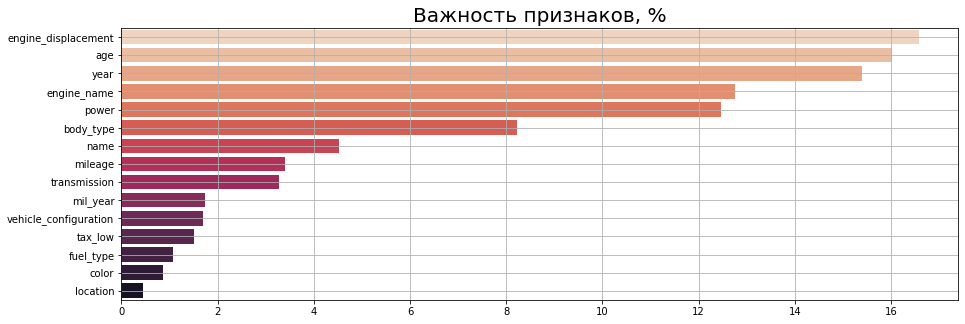

In [135]:
plt.figure(figsize=(15, 5))
sns.barplot(
    data=cat_bl.get_feature_importance(prettified=True),
    x="Importances",
    y="Feature Id",
    palette='rocket_r')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.grid()
plt.title('Важность признаков, %', fontsize=20)
plt.xlabel('', fontsize=15)
plt.ylabel('')

plt.show()

- В тройке лидеров среди признаков по важности для прогноза байзлайна модели CBoost: `engine_displacement = 16.57%`, `age = 16.02%` и `year = 15.40%`. Первые два признака были созданы входе фичинженеринга. 
- Замыкают пятерку лидеров такие признаки как: `engine_name = 12.77%` и `power = 12.47%`.
- Еще два созданных признака не показали ожидаемого вклада в прогноз модели - `mil_year = 1.75%` и `tax_low = 1.5%`, занимая 10 и 12 позиции в рейтинге.

In [82]:
# joblib.dump(cat_bl, 'cat_bl.pk1')

In [83]:
def objective_cat(trial, x, y, n_folds, random_state, cat_features):
    params_cat = {
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 3, 15),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 10.0),
        'loss_function': trial.suggest_categorical('loss_function', ['RMSE']),
        'eval_metric': trial.suggest_categorical('eval_metric', ['RMSE']),
        'random_state': trial.suggest_int('random_state', random_state, random_state)
    }

    cv = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)
    cv_pred_cat = np.empty(n_folds)

    for idx, (tra_idx, val_idx) in enumerate(cv.split(x, y)):
        x_tra, x_val = x.iloc[tra_idx], x.iloc[val_idx]
        y_tra, y_val = y[tra_idx], y[val_idx]

        train_data = Pool(data=x_tra, label=y_tra, cat_features=cat_features)
        val_data = Pool(data=x_val, label=y_val, cat_features=cat_features)

        cat = CatBoostRegressor(**params_cat)
        cat.fit(train_data, 
                eval_set=val_data,
                early_stopping_rounds=100, 
                verbose=0)
        preds_cat = cat.predict(x_val)
        cv_pred_cat[idx] = mean_squared_error(y_val, preds_cat, squared=False)

    return np.mean(cv_pred_cat)

In [118]:
study_cat = optuna.create_study(direction='minimize')


def opt_cat(trial):
    return objective_cat(
        trial,
        x=x_train_cat,
        y=y_train,
        n_folds=3,
        random_state=random_state,
        cat_features=tuple((toyota.select_dtypes(include=['object', 'category'])).columns))


study_cat.optimize(opt_cat,
                   n_trials=15,
                   show_progress_bar=True)

  0%|          | 0/15 [00:00<?, ?it/s]

In [84]:
study_cat = joblib.load("study_opt_cat.pk1")

In [85]:
print('Best RMSE:', study_cat.best_value)
print('Best parameters:', study_cat.best_params)

Best RMSE: 58755.711317454814
Best parameters: {'iterations': 1729, 'learning_rate': 0.07697927801615743, 'depth': 15, 'l2_leaf_reg': 0.6603348938667534, 'loss_function': 'RMSE', 'eval_metric': 'RMSE', 'random_state': 12345}


In [86]:
optuna.visualization.plot_optimization_history(study_cat)

In [87]:
optuna.visualization.plot_slice(study_cat)

In [88]:
optuna.visualization.plot_param_importances(study_cat)

In [89]:
optuna.visualization.plot_edf(study_cat)

- Для модели CBoost оптимальными параметрами для обучения ялвяются `iterations: 1729`, `learning_rate: 0.07697927801615743`, `depth: 15`, `l2_leaf_reg: 0.6603348938667534`, `loss_function: RMSE`, `eval_metric: RMSE`.
- На первом графике виден лишь один выброс, результаты остальных подборов планомерно улучшаются, приближаясь и концентрируясь около линии лучшего результата.
- Глубина деревьев улучшалась от модели к модели, планомерно приближаясь к лучшему результату.
- Признаками с наибольшим вкладом оказались глубина `deth`, `iterations` и `learning_rate` - 53%, 40№ и 7% соответственно
- Вероятность значительно улучшить полученные результаты низкая, что делает дальнейшее обучение не целесообразным.

In [80]:
cat_opt = CatBoostRegressor(**study_cat.best_params)
cat_opt.fit(x_train_cat, y_train, verbose=100, plot=True, cat_features=tuple(
    (toyota.select_dtypes(include=['object', 'category'])).columns))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1203416.6015944	total: 568ms	remaining: 16m 22s
100:	learn: 116386.7879964	total: 48s	remaining: 12m 53s
200:	learn: 84882.2312275	total: 1m 36s	remaining: 12m 9s
300:	learn: 70110.2256036	total: 2m 23s	remaining: 11m 22s
400:	learn: 62242.2302932	total: 3m 12s	remaining: 10m 38s
500:	learn: 57072.3090580	total: 4m 1s	remaining: 9m 50s
600:	learn: 54012.3321016	total: 4m 49s	remaining: 9m 4s
700:	learn: 51785.4297768	total: 5m 39s	remaining: 8m 17s
800:	learn: 50149.3287786	total: 6m 29s	remaining: 7m 31s
900:	learn: 48790.8568854	total: 7m 19s	remaining: 6m 44s
1000:	learn: 47735.5664902	total: 8m 10s	remaining: 5m 56s
1100:	learn: 47009.6772940	total: 9m	remaining: 5m 8s
1200:	learn: 46306.1530943	total: 9m 51s	remaining: 4m 20s
1300:	learn: 45721.9462165	total: 10m 42s	remaining: 3m 31s
1400:	learn: 45102.6012138	total: 11m 33s	remaining: 2m 42s
1500:	learn: 44606.4757078	total: 12m 25s	remaining: 1m 53s
1600:	learn: 44275.7439259	total: 13m 17s	remaining: 1m 3s
1700:	lear

In [90]:
# joblib.dump(study_cat, 'study_opt_cat.pk1')

In [91]:
# joblib.dump(cat_opt, 'cat_opt.pk1')

In [92]:
cat_opt = joblib.load("cat_opt.pk1")

In [93]:
predict_cat_opt = cat_opt.predict(x_test_cat)

In [136]:
cat_opt.get_feature_importance(prettified=True)

Feature Id  Importances
0                    year        15.11
1                   power        15.02
2     engine_displacement        13.75
3               body_type        10.13
4                     age         8.63
5             engine_name         7.96
6                 mileage         5.43
7                   color         5.41
8                mil_year         5.25
9                    name         3.82
10               location         2.93
11              fuel_type         2.47
12           transmission         1.75
13  vehicle_configuration         1.62
14                tax_low         0.71

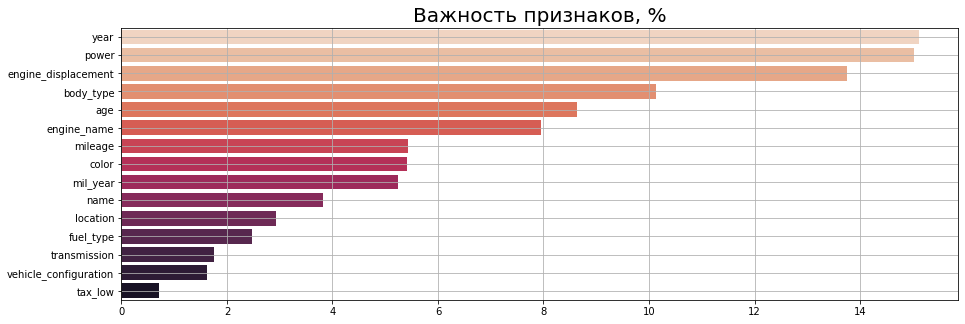

In [137]:
plt.figure(figsize=(15, 5))
sns.barplot(
    data=cat_opt.get_feature_importance(prettified=True),
    x="Importances",
    y="Feature Id",
    palette='rocket_r')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.grid()
plt.title('Важность признаков, %', fontsize=20)
plt.xlabel('', fontsize=15)
plt.ylabel('')

plt.show()

- В тройке лидеров среди признаков по важности для прогноза модели CBoost с подобранными гиперпараметрами: `year = 15.11%`, `power = 15.02%` и `engine_displacement = 13.75%`. Третий признак были созданы входе фичинженеринга. 
- Замыкают шестерку лидеров такие признаки как: `body_type = 10.13%`, `age = 8.63%` и `engine_name = 7.96%`.
- Еще два созданных признака не показали ожидаемого вклада в прогноз модели - `mil_year = 5.25%` и `tax_low = 0.71%`, занимая 9 и 15 позиции в рейтинге.

In [94]:
rmse_cat_opt = mean_squared_error(y_test, predict_cat_opt, squared=False)
mae_cat_opt = (mean_absolute_error(y_test, predict_cat_opt)).round(2)

print('RMSE =', rmse_cat_opt)
print('MAE =', mae_cat_opt)

RMSE = 53518.58937170504
MAE = 22136.68


# Анализ полученных результатов и сравнение моделей

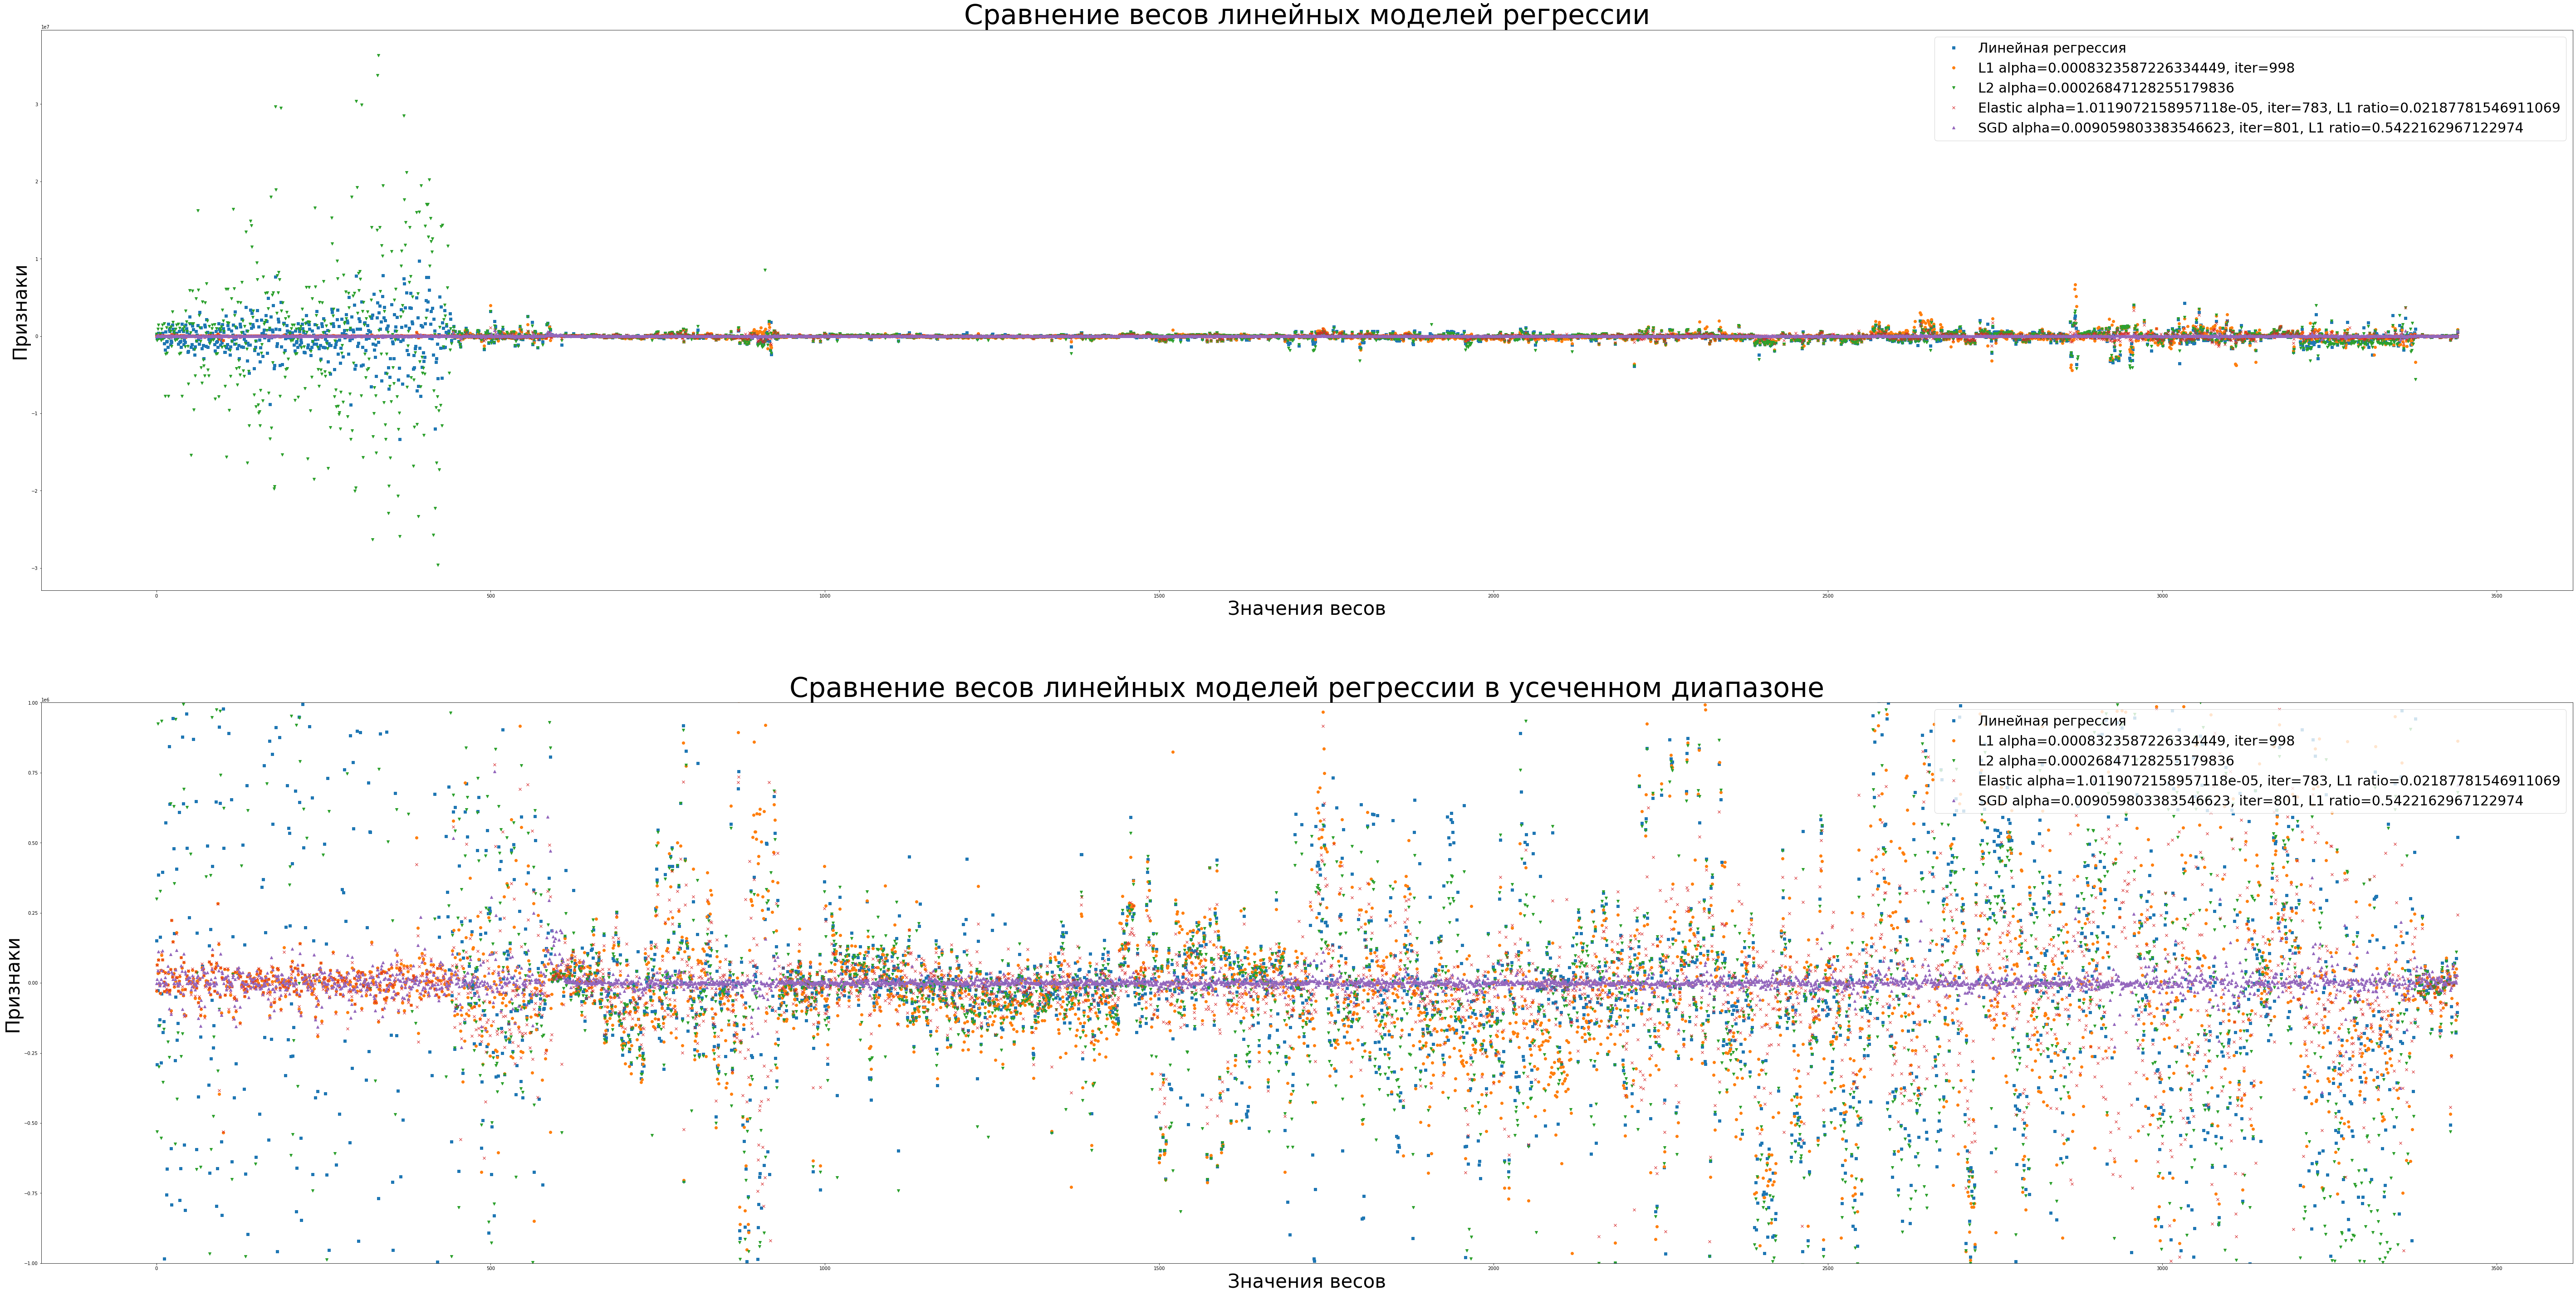

In [95]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(100, 50))

ax[0].plot(lr_poly.coef_, 's', label=f'Линейная регрессия')
ax[0].plot(ls_opt.coef_, 'o',
           label=f'L1 alpha={ls_opt.get_params()["alpha"]}, iter={ls_opt.get_params()["max_iter"]}')
ax[0].plot(rg_opt.coef_, 'v',
           label=f'L2 alpha={rg_opt.get_params()["alpha"]}')
ax[0].plot(elast_opt.coef_, 'x',
           label=f'Elastic alpha={elast_opt.get_params()["alpha"]}, iter={elast_opt.get_params()["max_iter"]}, L1 ratio={elast_opt.get_params()["l1_ratio"]}')
ax[0].plot(sgd_opt.coef_, '^',
           label=f'SGD alpha={sgd_opt.get_params()["alpha"]}, iter={sgd_opt.get_params()["max_iter"]}, L1 ratio={sgd_opt.get_params()["l1_ratio"]}')

ax[0].set_title('Сравнение весов линейных моделей регрессии', fontsize=60)
ax[0].set_xlabel('Значения весов', fontsize=42)
ax[0].set_ylabel('Признаки', fontsize=42)
# ax[0].hlines(0, 0, len(rg_opt.coef_), linestyles="solid",
#              colors="black", linewidth=3, label='Zero line')
ax[0].legend(title='', shadow=False,
             title_fontsize=45, fontsize=30, loc='upper right')


ax[1].plot(lr_poly.coef_, 's', label=f'Линейная регрессия')
ax[1].plot(ls_opt.coef_, 'o',
           label=f'L1 alpha={ls_opt.get_params()["alpha"]}, iter={ls_opt.get_params()["max_iter"]}')
ax[1].plot(rg_opt.coef_, 'v',
           label=f'L2 alpha={rg_opt.get_params()["alpha"]}')
ax[1].plot(elast_opt.coef_, 'x',
           label=f'Elastic alpha={elast_opt.get_params()["alpha"]}, iter={elast_opt.get_params()["max_iter"]}, L1 ratio={elast_opt.get_params()["l1_ratio"]}')
ax[1].plot(sgd_opt.coef_, '^',
           label=f'SGD alpha={sgd_opt.get_params()["alpha"]}, iter={sgd_opt.get_params()["max_iter"]}, L1 ratio={sgd_opt.get_params()["l1_ratio"]}')


ax[1].set_title(
    'Сравнение весов линейных моделей регрессии в усеченном диапазоне', fontsize=60)
ax[1].set_xlabel('Значения весов', fontsize=42)
ax[1].set_ylabel('Признаки', fontsize=42)
# ax[1].hlines(0, 0, len(rg_opt.coef_), linestyles="solid",
#              colors="black", linewidth=3, label='Zero line')
ax[1].legend(title='', shadow=False,
             title_fontsize=45, fontsize=30, loc='upper right')
ax[1].set_ylim([-1000000, 1000000])


plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30)
plt.show()

In [96]:
coef_reg = pd.DataFrame(list(lr_poly.coef_), columns=['lr_coef'])
coef_reg['rg_coef'] = list(rg_opt.coef_) 
coef_reg['ls_coef'] = list(ls_opt.coef_)
coef_reg['elast_coef'] = list(elast_opt.coef_) 
coef_reg['sgd_coef'] = list(sgd_opt.coef_)

In [97]:
predict_reg = pd.DataFrame(list(lr_poly_prediction), columns=['lr_pred'])
predict_reg['rg_pred'] = list(predict_rg_opt)
predict_reg['ls_pred'] = list(predict_ls_opt)
predict_reg['elast_pred'] = list(predict_elast_opt) 
predict_reg['sgd_pred'] = list(predict_sgd_opt)
predict_reg['target'] = list(y_test)

In [98]:
def describe_plus(df):
    l = []
    for col in df.columns:
        if (df[col].dtype == np.float64 or df[col].dtype == np.int64):
            count = df[col].count()
            mean = df[col].mean()
            std = df[col].std()
            min_n = df[col].min()
            per_1, per_25, per_50, per_75, per_99 = np.percentile(df[col], [
                1, 25, 50, 75, 99
            ])
            max_n = df[col].max()
            iqr = per_75 - per_25
            min_1_5_iqr = per_25 - 1.5*iqr
            if min_1_5_iqr < min_n:
                min_1_5_iqr = min_n
            max_1_5_iqr = per_75 + 1.5*iqr
            if max_1_5_iqr > max_n:
                max_1_5_iqr = max_n
            l.append([
                col, count, mean, std, min_n, per_1, per_25, per_50, per_75, per_99, max_n, iqr, min_1_5_iqr, max_1_5_iqr
            ])
    df_describe = pd.DataFrame(l)
    df_describe.columns=[
        'column', 'count', 'mean', 'std', 'min', '1%', '25%', '50%', '75%', '99%', 'max', 'iqr', '-1.5iqr', '+1.5iqr'
    ]
    df_describe = df_describe.set_index('column')
    return df_describe

In [99]:
describe_plus(coef_reg).T

column       lr_coef      rg_coef     ls_coef  elast_coef   sgd_coef
count        3443.00      3443.00     3443.00     3443.00    3443.00
mean       -37912.28    -64643.98   -19282.70   -11701.54    3051.77
std       1074262.19   3301840.69   515967.87   256529.73   45165.08
min     -13336921.40 -29607436.56 -4443821.85 -1594468.76 -389716.77
1%       -3711258.55 -11839269.02 -1435246.03  -691237.11 -108235.70
25%       -221065.12   -258590.55  -149747.83   -92468.69   -6291.02
50%        -23369.55    -29791.22   -22492.35   -10818.76     326.51
75%        142386.77    140895.32    74937.30    52435.61    8441.09
99%       3578372.72  13915675.67  1525337.51   748253.36  150066.62
max       9693842.41  36306409.61  6642947.99  3695527.61  753874.79
iqr        363451.88    399485.87   224685.14   144904.30   14732.11
-1.5iqr   -766242.95   -857819.36  -486775.54  -309825.14  -28389.18
+1.5iqr    687564.59    740124.13   411965.01   269792.06   30539.25

In [100]:
describe_plus(predict_reg).T

column      lr_pred     rg_pred     ls_pred  elast_pred    sgd_pred  \
count     125164.00   125164.00   125164.00   125164.00   125164.00   
mean     1497014.02  1497059.25  1497049.88  1497076.06  1489920.58   
std      1282475.13  1282319.02  1281610.45  1279629.45  1250708.44   
min      -194697.97  -170252.10  -126369.15   -98121.38  -275977.55   
1%        106913.42   112346.55   111831.67   114995.26    76095.84   
25%       614461.43   614349.57   617226.07   618432.53   614462.06   
50%      1007237.41  1008136.07   999317.14   998812.46  1026526.10   
75%      2156826.24  2155082.54  2160844.04  2161354.07  2120591.53   
99%      6190201.72  6188026.95  6134735.56  6144261.13  5693804.47   
max     13759090.51 13946842.83 13322485.89 13221813.24 12699682.35   
iqr      1542364.81  1540732.96  1543617.98  1542921.54  1506129.46   
-1.5iqr  -194697.97  -170252.10  -126369.15   -98121.38  -275977.55   
+1.5iqr  4470373.45  4466181.98  4476271.01  4475736.38  4379785.72   

column       target  
count     125164.00  
mean     1497319.61  
std      1294675.92  
min        33000.00  
1%        100000.00  
25%       605000.00  
50%      1000000.00  
75%      2150000.00  
99%      6180000.00  
max     14000000.00  
iqr      1545000.00  
-1.5iqr    33000.00  
+1.5iqr  4467500.00

- На первом графике видно, что большая часть значений весовых коэффициентов используемых линейных моделей сосредоточена в области близкой к нулю, однако исхдя из масштаба по оси y, и разбросу значений, можно сделать вывод об очень больших значениях для первых примерно 500 признаков, которые являются полиномами.
- При близком рассмотрении заметно, что основная часть коэффициентов также как и для остальных признаков сосредоточена в одной линии, кроме коэффициентов моделей классической линейной регрессии и регрессии с L2 регуляризацией. При этом разброс значений для модели с L2 регуляризацией ощутимо больше.
- При усеченом масштабе по оси у на втором графике очевидна разница в весах каждой модели. Коэффициенты градиентного спуска сосредоточеный в одной линии, фактически заменяя zero line. Тенденция в отношении классической линейной регрессии и регрессии с L2 регуляризацией тенденция остается прежней.
- Предположения по результатам графиков подверждаются данными описательной статистики. L2 регуляризация демонстрирует самые крайние значения максимальных и минимальных значений коэффициентов, по сравнению с другими моделями. Градиентный спуск оказывается самым строгим на штрафы и показывает самые низкие по модулю значения весовых коэффициентов.
- Однако при оценке предиктов и сравнения их с целевым значенийм, оказывается что не смотря на самые сдержанные коэффециенты, градиентный спуск демонстрирует самые далекие от таргета значения. Классическая линейная регрессия оказалась точнее всего.

In [101]:
models_metrics = get_metrics(lr_poly, x_train, y_train, y_test, lr_poly_prediction, name='LR baseline')

In [102]:
models_metrics = models_metrics.append(get_metrics(
    cat_bl, x_train_cat, y_train, y_test, predict_cat_bl, name='CatBoost baseline'))
models_metrics = models_metrics.append(get_metrics(
    rg_opt, x_train, y_train, y_test, predict_rg_opt, name='Ridge optuna'))
models_metrics = models_metrics.append(get_metrics(
    ls_opt, x_train, y_train, y_test, predict_ls_opt, name='Lasso optuna'))
models_metrics = models_metrics.append(get_metrics(
    elast_opt, x_train, y_train, y_test, predict_elast_opt, name='ElasticNet optuna'))
models_metrics = models_metrics.append(get_metrics(
    sgd_opt, x_train, y_train, y_test, predict_sgd_opt, name='SGDRegression optuna'))
models_metrics = models_metrics.append(get_metrics(
    cat_opt, x_train_cat, y_train, y_test, predict_cat_opt, name='CatBoost optuna'))

In [103]:
models_metrics

model       MAE            MSE      RMSE RMSLE   R2  MPE_%  \
0           LR baseline  99535.46 30502194639.03 174648.78  None 0.98  -2.12   
0     CatBoost baseline  83816.32 16253441546.56 127488.99  None 0.99  -2.72   
0          Ridge optuna  99136.29 30334054485.22 174166.74  None 0.98  -2.14   
0          Lasso optuna 101588.11 32580755134.23 180501.40  None 0.98  -2.24   
0     ElasticNet optuna 104427.53 33423753384.72 182821.64  None 0.98  -2.50   
0  SGDRegression optuna 165964.84 85883265926.81 293058.47  None 0.95  -3.62   
0       CatBoost optuna  22136.68  2864239408.34  53518.59  None 1.00  -0.28   

   MAPE_%  WAPE_%  OF_R2_%  OF_RMSE_%  OF_MAE_%  
0   10.09    6.65     0.04       1.36      0.32  
0    9.97    5.60     0.00       0.45      0.73  
0   10.04    6.62     0.04       1.28      0.45  
0   10.00    6.78     0.05       1.43      0.16  
0   10.48    6.97     0.05       1.44      0.15  
0   17.69   11.08     0.19       1.86      0.09  
0    1.96    1.48     0.02       5.93      2.58

- Все модели довольно отлично описывают данные (r2). Явно выделяются лишь SGD (0,95) с самым наихудшим результатом, и модели CatBoost, показывающие наилучшие результаты (0,99 и 1,0).
- Что касается оценки ключевой метрики RMSE байзлан линейной регресии показывает сопоставимые результаты с L2 регуляризацией (174648,78 и 174166,74 соответственно) и опережает по данному показателю остальные линейные модели. Таблица лидеров при оценке коэффициентов противоположна оценке метрики, самая жестокая с точки зрения штрафов SGD продемонстрировала самый худший результат (293058,47). Лидерами с большим отрывом выступают модели CBoost базлайн и CBoost с подобранными гиперпараметрами (127488,99 и 53518,59). Ожидаемая картина наблюдается и при оцнке MSE.
- Все линейные модели кроме SGD достигли МАЕ около 100 000, тогда как SGB лишь 165964,84. Байзлайн СBoost продемонстрировал 83816,32, тогда как лидером среди всех моделей оказалась подобранная модель СBoost с результатом 22136,68.
- Линейные модели показали близкие результаты по метрикам MPE и MAPE (около -2,2% и 10% соответственно). Антигероем опять выступила модель SGD с результатами -3,52% и 17,09%. Байзлайн CBoost по средней относительной ошибке оказался даже хуже линейных моделей (-2,72%), но сохранил позицию по абсолютной доле ошибок (9,97). Тюнингованный СBoost очень сильно опережает все модели, допуская гораздо меньше ошибок (-0,28% и 1,96% соответственно). В целом все модели склонны недооценивать прогнозируемые результаты стоимости, что удивительно.
- По метрике WAPE сохраняется привычная нам тендеция, с отставанием SGD (11,08%), средними результатами оставшихся лиейных моделей и байзлайна CBoost (от 5,5% до 6,97%) и лидерством модели СBoost с подобранными гиперпараметрами (1,48%).
- Оверфитинг оценивался по дельте между обучающей и тестовой выборок таких метрик как R2, RMSE и MAE. По R2 все модели показали сопоставимые результаты от 0 до 0,05%, кроме антилидера SGD с результатом в 0,19%. Лидером по дельте RMSE оказалась модель байзлайн CBoost с резйльтатом в 0,45%. Линейные модели показали сопоставимые результаты с антигероем в лице SGD (1,86%). Ну и замыкает хит-парад тюниный CBoost с результатом 5,93%. Довольно высокий показатель, но ожидаемый результат, учитывая RMSE в качестве ключевой метрики для минимизаии и столь внушительными результатами по остальным метрикам. Удивляет скорее худшие результаты как по основным метрикам, так и по оверфитингу для модели SGD. Однако по дельте МАЕ SGD лидер (0,09%). Средний эшелон замыкает байзлайн CBoost (0,73%), и абсолютный антилидер модель с подобранным параметрами CBoost (2,58), что является вполне приемлимым результтом. 
- Резюмируя, линейные модели довольно средне справляются с поставленной задачей, при этом лидером как с точки зрения резуьтатов по оцениваемым метрикам, так и с точки зрения время и трудозатрат является байзлайн линейной регрессии. Стохастический градиентный спуск продемонстрировал самые худшие показатели. Самой сбалансированной моделью с точки зрения метрик и оверфитинга является байзлайн CBoost. Самым результативным, но при этом и более переобученным в сравнении с остальными получилась тюнингованная модель CBoost. Однако внушительные показатели метрик могут перекрыть оверфитинг.

# Моделирование на полном датасете

In [104]:
df = df.drop('lifetime', axis=1)

In [106]:
train_all, test_all = train_test_split(df, test_size=.25, stratify = df['name'], random_state=random_state)

In [107]:
x_train_all = train_all.drop(['price'], axis=1)
y_train_all = train_all['price'].values

x_test_all = test_all.drop(['price'], axis=1)
y_test_all = test_all['price'].values

In [110]:
study_cat_all = optuna.create_study(direction='minimize')


def opt_cat_all(trial):
    return objective_cat(
        trial,
        x=x_train_all,
        y=y_train_all,
        n_folds=3,
        random_state=random_state,
        cat_features=tuple((df.select_dtypes(include=['object', 'category'])).columns))


study_cat_all.optimize(opt_cat_all,
                   n_trials=15,
                   show_progress_bar=True)

[I 2023-06-13 18:45:06,215] A new study created in memory with name: no-name-5f006a89-0104-44bf-b314-4c8d18ddbdf3


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2023-06-13 18:46:42,754] Trial 0 finished with value: 355846.7835972919 and parameters: {'iterations': 493, 'learning_rate': 0.0917494401302767, 'depth': 3, 'l2_leaf_reg': 0.0556306584439918, 'loss_function': 'RMSE', 'eval_metric': 'RMSE', 'random_state': 12345}. Best is trial 0 with value: 355846.7835972919.
[I 2023-06-13 18:58:19,053] Trial 1 finished with value: 198528.68294196317 and parameters: {'iterations': 1998, 'learning_rate': 0.06784970157435989, 'depth': 5, 'l2_leaf_reg': 0.0002032323549918134, 'loss_function': 'RMSE', 'eval_metric': 'RMSE', 'random_state': 12345}. Best is trial 1 with value: 198528.68294196317.
[I 2023-06-13 20:11:15,898] Trial 2 finished with value: 104269.15312719218 and parameters: {'iterations': 1874, 'learning_rate': 0.019260499035421867, 'depth': 15, 'l2_leaf_reg': 1.630983376726429e-05, 'loss_function': 'RMSE', 'eval_metric': 'RMSE', 'random_state': 12345}. Best is trial 2 with value: 104269.15312719218.
[I 2023-06-13 20:16:40,828] Trial 3 finish

In [123]:
rmse_cat_opt_all = mean_squared_error(y_test_all, predict_cat_opt_all, squared=False)
mae_cat_opt_all = (mean_absolute_error(y_test_all, predict_cat_opt_all)).round(2)

print('RMSE =', rmse_cat_opt_all)
print('MAE =', mae_cat_opt_all)
print('Best parameters:', study_cat_all.best_params)

RMSE = 99324.87855784984
MAE = 44188.03
Best parameters: {'iterations': 1680, 'learning_rate': 0.02313476893424002, 'depth': 15, 'l2_leaf_reg': 1.7100347673754728e-05, 'loss_function': 'RMSE', 'eval_metric': 'RMSE', 'random_state': 12345}


In [119]:
optuna.visualization.plot_optimization_history(study_cat_all)

In [120]:
optuna.visualization.plot_slice(study_cat_all)

In [121]:
optuna.visualization.plot_param_importances(study_cat_all)

In [122]:
optuna.visualization.plot_edf(study_cat_all)

- Для предсказания стоимости автомобилей по всем объявлениям Приморского края моделью CBoost оптимальными параметрами для обучения ялвяются `iterations: 1680`, `learning_rate: 0.02313476893424002`, `depth: 15`, `l2_leaf_reg: 1.7100347673754728e-05`, `loss_function: RMSE`, `eval_metric: RMSE`.
- На основании первого и последнего графиков видно, что подбор оптимальных параметров модели далек от выхода на плато и имеется довольная большая вероятность получить более значимые результаты по минимизации ключевой метрики RMSE. Целесообразно продолжить подбор гиперпараметров для улучшения прогностической модели.
- Глубина деревьев улучшалась от модели к модели, планомерно приближаясь к лучшему результату. Однако этот результат максимально допустимый в нашем подборе (15) и дальнейшее увеличение глубины деревьев может привезти к значительному переобучению модели в погоне за минимизацией метрики. подбор остальных параметров далек от какой либо структуры судя по графику. Данный факт также говорит нам о целесообразности продолжения подбора оптимальных гиперпараметров для модели CBoost.
- Признаками с наибольшим вкладом оказались глубина `deth`, `iterations` и `learning_rate` - 43%, 31№ и 26% соответственно. Схожая картина с подбором моделью для объявлений о продаже машин только марки Toyota, однако с большим смещением ценности в сторону `learning_rate`. 

In [112]:
cat_opt_all = CatBoostRegressor(**study_cat_all.best_params)
cat_opt_all.fit(x_train_all, y_train_all, verbose=100, plot=True, cat_features=tuple(
    (df.select_dtypes(include=['object', 'category'])).columns))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1639177.9751010	total: 916ms	remaining: 25m 38s
100:	learn: 335828.8261814	total: 1m 31s	remaining: 23m 47s
200:	learn: 214148.6603513	total: 3m	remaining: 22m 4s
300:	learn: 180286.0718327	total: 4m 37s	remaining: 21m 9s
400:	learn: 160644.6675967	total: 6m 17s	remaining: 20m 4s
500:	learn: 146026.2076426	total: 7m 56s	remaining: 18m 41s
600:	learn: 135315.6118946	total: 9m 29s	remaining: 17m 2s
700:	learn: 126862.5944650	total: 11m 1s	remaining: 15m 23s
800:	learn: 120352.2896674	total: 12m 38s	remaining: 13m 52s
900:	learn: 115057.5477886	total: 14m 14s	remaining: 12m 18s
1000:	learn: 110263.7781222	total: 15m 49s	remaining: 10m 43s
1100:	learn: 106674.9994930	total: 17m 24s	remaining: 9m 9s
1200:	learn: 103364.4579814	total: 18m 58s	remaining: 7m 34s
1300:	learn: 100674.8610692	total: 20m 33s	remaining: 5m 59s
1400:	learn: 98387.8738772	total: 22m 8s	remaining: 4m 24s
1500:	learn: 96200.2829612	total: 23m 43s	remaining: 2m 49s
1600:	learn: 94273.6014569	total: 25m 20s	rem

In [113]:
predict_cat_opt_all = cat_opt_all.predict(x_test_all)

In [129]:
cat_opt_all.get_feature_importance(prettified=True)

Feature Id  Importances
0                   power        19.34
1                     age        10.77
2     engine_displacement        10.08
3               body_type         9.95
4                    year         9.60
5                 mileage         6.41
6                mil_year         5.84
7                   color         5.50
8                   brand         5.39
9             engine_name         5.06
10                country         2.92
11              fuel_type         2.78
12           transmission         2.39
13                   name         2.16
14  vehicle_configuration         0.86
15               location         0.83
16                tax_low         0.13

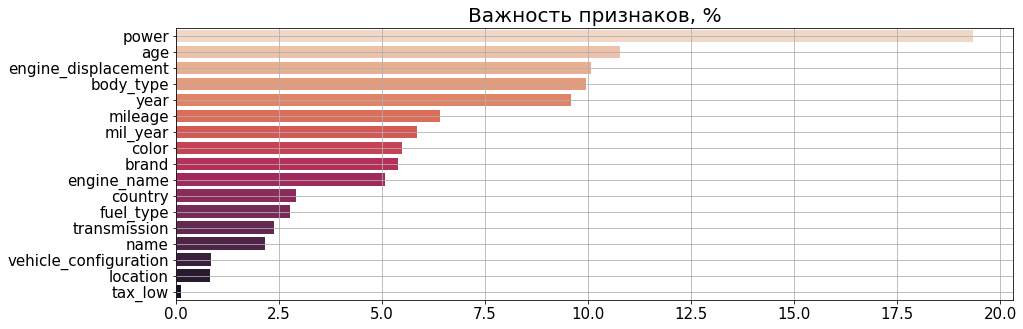

In [132]:
plt.figure(figsize=(15, 5))
sns.barplot(
    data=cat_opt_all.get_feature_importance(prettified=True),
    x="Importances",
    y="Feature Id",
    palette='rocket_r')
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.grid()
plt.title('Важность признаков, %', fontsize=20)
plt.xlabel('', fontsize=15)
plt.ylabel('')

plt.show()

- Абсолютным лидером среди всех признаков по важности вклада в прогноз модели CBoost для предсказания стоимости автомобилей Приморского края является `power = 19.34%`
- Замыкают пятерку лидеров такие признаки как: `age = 10.77%`, `engine_displacement = 10.08%`, `body_type = 9.95%` и `year = 9.60%`. Возраст и объем двигателя автомобилей были созданы в ходе фичинженеринга.
- Еще два созданных признака не показали ожидаемого вклада в прогноз модели - `mil_year = 5.84%` и `tax_low = 0.13%`, занимая 7 и 17 позиции в рейтинге.

In [115]:
all_metrics = get_metrics(cat_opt_all, x_train_all, y_train_all, y_test_all, predict_cat_opt_all, name='Cat Boost opt all')

In [118]:
all_metrics

model      MAE           MSE     RMSE RMSLE   R2  MPE_%  \
0  Cat Boost opt all 44188.03 9865431500.53 99324.88  None 1.00  -1.23   

   MAPE_%  WAPE_%  OF_R2_%  OF_RMSE_%  OF_MAE_%  
0    5.10    2.98     0.00       0.12      1.95

- Получены довольно неплохие результаты по оценке качества модели, однако мы проводили анализ лишь одной модели, а большинство из метрик имеют значимость лишь при сравнительной характеристике с результатами по итогам обучения других моделей.
- МАЕ и RMSE приемлимы для использования модели - 44188.03 и 99324.88 соответственно.
- Модель в своих прогнозах скорее недооценивает реальную стоимость автомобилей, чем наоборот. MPE, MAPE и WAPE - 1.23%, 5.10% и 2.98% соответсвенно. Модель довольно часто ошибается. В совокупности с довольно низким оверфитингом (OF_R2 = 0.00%, OF_RMSE = 0.12% и OF_MAE = 1.95%) говорит нам о наличии потенциала к продолжению поиска опстимальных параметров. Однако учитывая достигнуты потолок в 15 итераций по самому ценнуму параметру не приведет к кратному улучшению метрики.

In [116]:
# joblib.dump(study_cat_all, 'study_cat_all.pk1')

['study_cat_all.pk1']

In [117]:
# joblib.dump(cat_opt_all, 'cat_opt_all.pk1')

['cat_opt_all.pk1']